# Pneumonia Detection using CNN and Object Detection
## Capstone project

This notebook Goal is to look at given set of chest X-Ray images and create a model to classify whether a patient have Lung Opacity or not. If there is a lung opacity, provide marking. There is a third class "No lung opacity/Not normal" which is nothing but there is no peunomonia but the lung doesnot look normal too. We can optionally have marking for the third class.

### We have three milesone

#### Milestone 1: 
Create a model to do classification of given patient dicom(xray) images to either they have Pneumonia or normal or no pneumonia/not normal.

#### Milestone 2: 
Fine tune model, Apply Transfer learning and Perform object detection

#### Milestone 3:
Deploy model with UI


# ------------------------------ Milestone 1 ------------------------------ 

In [3]:
%matplotlib inline

import math as math
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile

# Step - 1. Import the data

In [4]:
zip_directory='/tmp'

In [5]:
#from google.colab import drive
#drive.mount('/content/drive/')
#mainZipFile = ZipFile("drive/My Drive/Colab Notebooks/CV capstone-20230330T235201Z-002.zip", 'r')
#mainZipFile.extractall(zip_directory)
#mainZipFile.close()

In [6]:
mainZipFile = ZipFile("CV capstone-20230330T235201Z-002.zip")
mainZipFile.extractall(zip_directory)

### Step - 1.1. List all files inside zip

In [7]:
mainZipFile.filelist

[<ZipInfo filename='CV capstone/stage_2_sample_submission.csv' compress_type=deflate file_size=159027 compress_size=65360>,
 <ZipInfo filename='CV capstone/stage_2_detailed_class_info.csv' compress_type=deflate file_size=1647396 compress_size=597052>,
 <ZipInfo filename='CV capstone/stage_2_train_labels.csv' compress_type=deflate file_size=1490034 compress_size=676860>,
 <ZipInfo filename='CV capstone/GCP Credits Request Link - RSNA.txt' compress_type=deflate file_size=55 compress_size=57>,
 <ZipInfo filename='CV capstone/stage_2_test_images.zip' compress_type=deflate file_size=397164167 compress_size=397224772>]

###### We have three csv and zip file
###### We have another Link file which we can ignore as it is having only credit information


### Step - 1.2: Read all csv files and check content

In [8]:
train_label_df = pd.read_csv("CV capstone/stage_2_train_labels.csv")
sample_submission_df = pd.read_csv("CV capstone/stage_2_sample_submission.csv")
class_info_df = pd.read_csv("CV capstone/stage_2_detailed_class_info.csv")

In [9]:
class_info_df

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


In [10]:
sample_submission_df

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100
...,...,...
2995,c1e88810-9e4e-4f39-9306-8d314bfc1ff1,0.5 0 0 100 100
2996,c1ec035b-377b-416c-a281-f868b7c9b6c3,0.5 0 0 100 100
2997,c1ef5b66-0fd7-49d1-ae6b-5af84929414b,0.5 0 0 100 100
2998,c1ef6724-f95f-40f1-b25b-de806d9bc39d,0.5 0 0 100 100


###### The submission CSV file will be useful to verify the result of model and come up with accuracy measurement.

In [11]:
train_label_df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


###### The lable file has patientid and coordinates
###### The total number of records in class_info_df is higher than train_label_df which we should check later for any duplicates

<AxesSubplot:xlabel='Target', ylabel='count'>

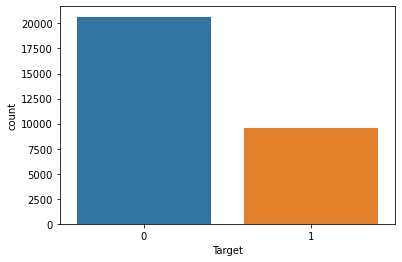

In [12]:
sns.countplot(x=train_label_df['Target'])

In [13]:
#sns.countplot(x=class_info_df['class'])

### Step - 1.3: We have training images in  zip file.

In [14]:
training_image_zip_file="CV capstone/stage_2_train_images-001.zip"
trainImgZipFile = ZipFile(training_image_zip_file, 'r')
trainImgZipFile.extractall(zip_directory + "/train_images")
trainImgZipFile.close()
trainImgZipFile.filelist

[<ZipInfo filename='stage_2_train_images/' filemode='drwxr-xr-x'>,
 <ZipInfo filename='__MACOSX/._stage_2_train_images' compress_type=deflate filemode='-rwxr-xr-x' file_size=212 compress_size=135>,
 <ZipInfo filename='stage_2_train_images/7be6b4de-afe9-43c0-a581-0f49608c8976.dcm' compress_type=deflate filemode='-rw-rw-r--' file_size=149466 compress_size=147827>,
 <ZipInfo filename='__MACOSX/stage_2_train_images/._7be6b4de-afe9-43c0-a581-0f49608c8976.dcm' compress_type=deflate filemode='-rw-rw-r--' file_size=212 compress_size=135>,
 <ZipInfo filename='stage_2_train_images/2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm' compress_type=deflate filemode='-rw-rw-r--' file_size=163514 compress_size=162647>,
 <ZipInfo filename='__MACOSX/stage_2_train_images/._2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm' compress_type=deflate filemode='-rw-rw-r--' file_size=212 compress_size=135>,
 <ZipInfo filename='stage_2_train_images/d8e66874-305e-4c80-9b75-5e764eb718ff.dcm' compress_type=deflate filemode='-rw-rw-r-

### Step 1.4:  Let us look at few images

In [15]:
# We have dicom images and hence we need pydicom
!pip install pydicom

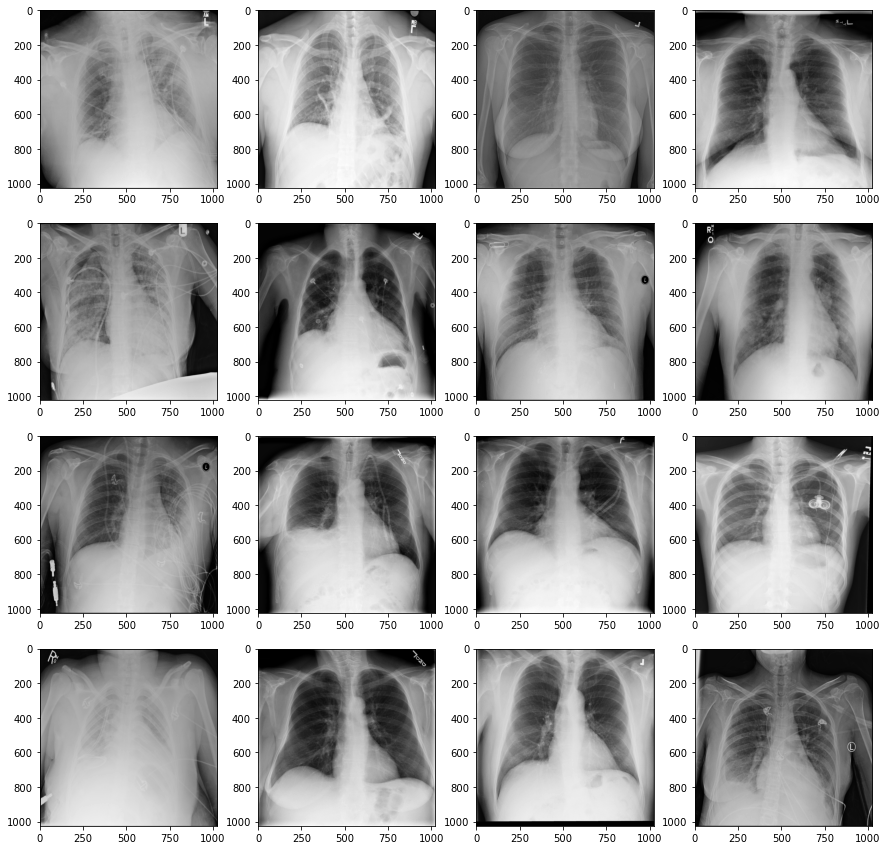

In [16]:
# Print few images with its class 
import random
import pydicom as dicom

fig = plt.figure(figsize=(15, 15))
N=16
for i in range(1, N+1):
    #loc = random.randint(1, total_number_of_files)
    random_file=random.choice(os.listdir(zip_directory + "/train_images/stage_2_train_images"))
    #print(random_file)
    fig.add_subplot(4, 4, i)
    dicom_image = dicom.dcmread(zip_directory + "/train_images/stage_2_train_images/" + random_file)
    plt.imshow(dicom_image.pixel_array, cmap=plt.cm.gray)
   # plt.title(data.loc[loc, 'class'])
   # plt.axis('off')
plt.show()

## Step - 2 & 3. Map training and testing images to its classes and Annotations

### Step 2.1 Iterate over image directory, resize images to 32  * 32 and normalize the image array. Also store the original image size in a dataframe


In [17]:
!pip install tensorflow_io

In [18]:
import os
import pydicom as dicom
import skimage.transform as st
import tensorflow as tf
import tensorflow_io as tfio

image_directory = zip_directory + "/train_images/stage_2_train_images"
total_number_of_files = 0
image_df = pd.DataFrame(columns=['image_file_name', 'path', 'actual_image', 'height', 'width'])

# Iterate directory
i = 0
for file in os.listdir(image_directory):
    # check if current path is a file
    if os.path.isfile(os.path.join(image_directory, file)):
        total_number_of_files += 1
        dicom_image = dicom.dcmread(os.path.join(image_directory, file))
        image_df.loc[i, 'path'] = os.path.join(image_directory, file)
        image_df.loc[i, 'image_file_name'] = file
        #image_df.loc[i, 'patientId'] = data.loc[loc, 'patientId']
        #image_df.loc[i, 'actual_image'] = dicom_image.pixel_array 
        image_df.loc[i, 'actual_image'] = np.array((st.resize(dicom_image.pixel_array, (32, 32), anti_aliasing=True))/255)
                
        image_df.loc[i, 'height'] = dicom_image.Columns
        image_df.loc[i, 'width'] = dicom_image.Rows
        i+=1
        #if (i == 100):
        #    break
print(f"We have {total_number_of_files} total number of image files");


We have 26684 total number of image files


In [19]:
image_df

,image_file_name,path,actual_image,height,width
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,/tmp/train_images/stage_2_train_images\0004cfa...,"[[8.286463581287197e-05, 4.041750331910769e-05...",1024,1024
1,000924cf-0f8d-42bd-9158-1af53881a557.dcm,/tmp/train_images/stage_2_train_images\000924c...,"[[7.194814904496719e-05, 0.0002037581145740258...",1024,1024
2,000db696-cf54-4385-b10b-6b16fbb3f985.dcm,/tmp/train_images/stage_2_train_images\000db69...,"[[4.487527018563684e-05, 4.5375053597157953e-0...",1024,1024
3,000fe35a-2649-43d4-b027-e67796d412e0.dcm,/tmp/train_images/stage_2_train_images\000fe35...,"[[0.0002417167778605627, 0.0002527935192363741...",1024,1024
4,001031d9-f904-4a23-b3e5-2c088acd19c6.dcm,/tmp/train_images/stage_2_train_images\001031d...,"[[6.772987099858779e-05, 0.0003000979514369435...",1024,1024
...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3.dcm,/tmp/train_images/stage_2_train_images\fffb239...,"[[7.163705612606939e-05, 6.700455796513645e-05...",1024,1024
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27.dcm,/tmp/train_images/stage_2_train_images\fffba05...,"[[4.6134528863375316e-05, 4.610083468755934e-0...",1024,1024
26681,fffc95b5-605b-4226-80ab-62caec682b22.dcm,/tmp/train_images/stage_2_train_images\fffc95b...,"[[0.0003491565798057978, 0.000770259978522427,...",1024,1024
26682,fffcff11-d018-4414-971a-a7cefa327795.dcm,/tmp/train_images/stage_2_train_images\fffcff1...,"[[1.344063738425597e-05, 4.654971683902636e-07...",1024,1024


## Step - 2.2 The image_file_name has both extension and patienid. Split and store it.

In [20]:
image_df[['patientId', 'extension']] = image_df['image_file_name'].str.split('.', 1, expand=True)

In [21]:
image_df.shape

(26684, 7)

In [22]:
# Check if we have duplicates. We have seen trining label was having 30227 records which means 
# we have duplicate in the label CSV hence remove it
image_df[image_df.duplicated('patientId') == True]

,image_file_name,path,actual_image,height,width,patientId,extension


## Step 2.3 Train label CSV sounds like having some duplicate - remove it.

In [23]:
train_label_df = train_label_df[train_label_df.duplicated('patientId') == False]

In [24]:
train_label_df.shape

(26684, 6)

###### Now, we have three dataframe. The image_df have all images loaded with its attributes, we have train_label_df having all coordinates and we also have class_info_df with classification label for images. The common id between all three dataframe is 'pateientid' which we can use for mering them.

### Step - 3.1: Merge classes and Annotation dataframe with image

In [25]:
data = image_df.merge(train_label_df, on="patientId")

In [26]:
data.shape

(26684, 12)

In [27]:
class_info_df = class_info_df[class_info_df.duplicated('patientId') == False]

In [28]:
data = data.merge(class_info_df, on="patientId")

In [29]:
first_column = data.pop('patientId')
data.insert(0, 'patientId', first_column)

In [30]:
data

,patientId,image_file_name,path,actual_image,height_x,width_x,extension,x,y,width_y,height_y,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,/tmp/train_images/stage_2_train_images\0004cfa...,"[[8.286463581287197e-05, 4.041750331910769e-05...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,000924cf-0f8d-42bd-9158-1af53881a557,000924cf-0f8d-42bd-9158-1af53881a557.dcm,/tmp/train_images/stage_2_train_images\000924c...,"[[7.194814904496719e-05, 0.0002037581145740258...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,Normal
2,000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985.dcm,/tmp/train_images/stage_2_train_images\000db69...,"[[4.487527018563684e-05, 4.5375053597157953e-0...",1024,1024,dcm,316.0,318.0,170.0,478.0,1,Lung Opacity
3,000fe35a-2649-43d4-b027-e67796d412e0,000fe35a-2649-43d4-b027-e67796d412e0.dcm,/tmp/train_images/stage_2_train_images\000fe35...,"[[0.0002417167778605627, 0.0002527935192363741...",1024,1024,dcm,570.0,282.0,269.0,409.0,1,Lung Opacity
4,001031d9-f904-4a23-b3e5-2c088acd19c6,001031d9-f904-4a23-b3e5-2c088acd19c6.dcm,/tmp/train_images/stage_2_train_images\001031d...,"[[6.772987099858779e-05, 0.0003000979514369435...",1024,1024,dcm,66.0,160.0,373.0,608.0,1,Lung Opacity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,fffb2395-8edd-4954-8a89-ffe2fd329be3.dcm,/tmp/train_images/stage_2_train_images\fffb239...,"[[7.163705612606939e-05, 6.700455796513645e-05...",1024,1024,dcm,177.0,285.0,225.0,529.0,1,Lung Opacity
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,fffba05a-1635-4545-9bbd-57ad4cfe8d27.dcm,/tmp/train_images/stage_2_train_images\fffba05...,"[[4.6134528863375316e-05, 4.610083468755934e-0...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,Normal
26681,fffc95b5-605b-4226-80ab-62caec682b22,fffc95b5-605b-4226-80ab-62caec682b22.dcm,/tmp/train_images/stage_2_train_images\fffc95b...,"[[0.0003491565798057978, 0.000770259978522427,...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
26682,fffcff11-d018-4414-971a-a7cefa327795,fffcff11-d018-4414-971a-a7cefa327795.dcm,/tmp/train_images/stage_2_train_images\fffcff1...,"[[1.344063738425597e-05, 4.654971683902636e-07...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


# Step - 4: Preprocessing and Visualisation of different classes

## Step - 4.1 Print random images from merged dataframe along with its class

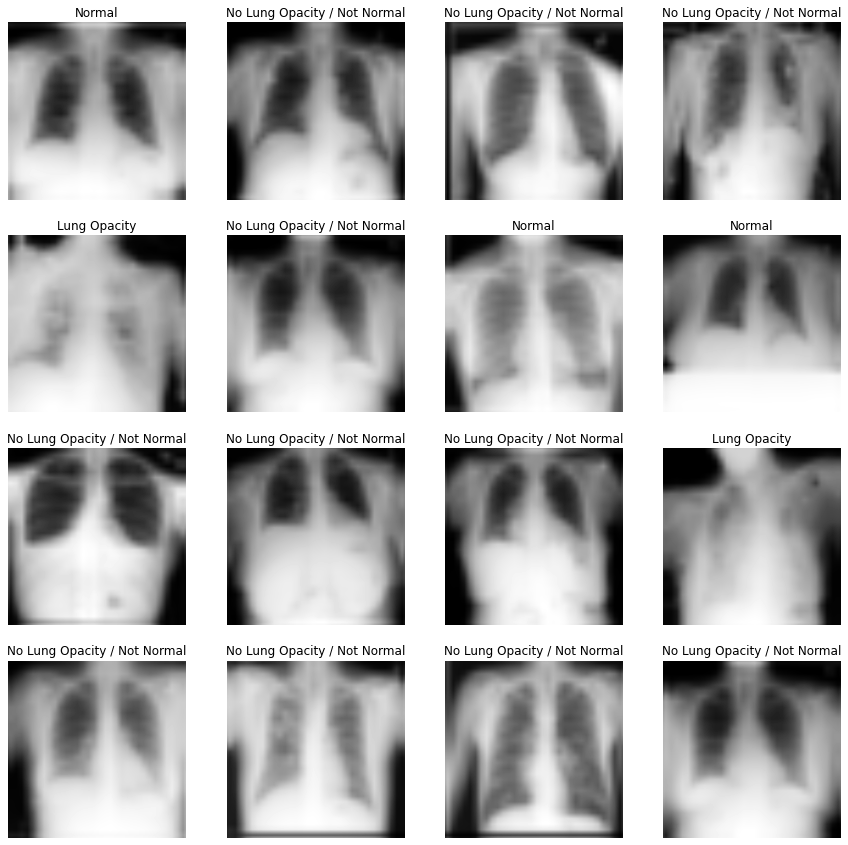

In [31]:
# Print few images with its class 
import random
import pydicom as dicom

fig = plt.figure(figsize=(15, 15))
N=16
for i in range(1, N+1):
    loc = random.randint(1, total_number_of_files)
    #random_file=random.choice(os.listdir(zip_directory + "/train_images/stage_2_train_images"))
    #print(random_file)
    fig.add_subplot(4, 4, i)
    #dicom_image = dicom.dcmread(data.loc[loc, 'actual_image'])    
    plt.imshow(st.resize(data.loc[loc, 'actual_image'],  (1024, 1024)),  cmap=plt.cm.gray)
    plt.title(data.loc[loc, 'class'])
    plt.axis('off')
plt.show()

##### We have lost the image quality after we have created dataframe with image array after resizing.

## Step - 4.2 Check the "Class" balance

In [32]:
#sns.countplot(x=data["class"])

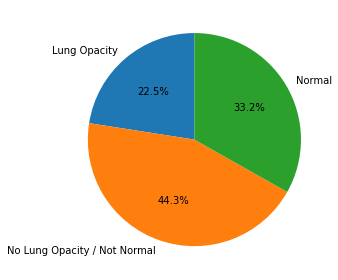

In [37]:
unique_values, count = np.unique(data['class'], return_counts=True)
plt.pie(count, labels = ['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'], autopct='%1.1f%%', startangle=90)
plt.tight_layout()

######  Class is not balanced. We should do something about it. The easiest theings to do is to downsampling which will still give good population of data (~18K). But for correct things to do for CNN is to do Image Augumentation which we will try in MIlestone - 2

## Step - 4.3: Let us encode class variable

In [38]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'class'.
data['class_no']= label_encoder.fit_transform(data['class'])
df = data.drop(labels='class', axis=1)
df

,patientId,image_file_name,path,actual_image,height_x,width_x,extension,x,y,width_y,height_y,Target,class_no
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,/tmp/train_images/stage_2_train_images\0004cfa...,"[[8.286463581287197e-05, 4.041750331910769e-05...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,1
1,000924cf-0f8d-42bd-9158-1af53881a557,000924cf-0f8d-42bd-9158-1af53881a557.dcm,/tmp/train_images/stage_2_train_images\000924c...,"[[7.194814904496719e-05, 0.0002037581145740258...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,2
2,000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985.dcm,/tmp/train_images/stage_2_train_images\000db69...,"[[4.487527018563684e-05, 4.5375053597157953e-0...",1024,1024,dcm,316.0,318.0,170.0,478.0,1,0
3,000fe35a-2649-43d4-b027-e67796d412e0,000fe35a-2649-43d4-b027-e67796d412e0.dcm,/tmp/train_images/stage_2_train_images\000fe35...,"[[0.0002417167778605627, 0.0002527935192363741...",1024,1024,dcm,570.0,282.0,269.0,409.0,1,0
4,001031d9-f904-4a23-b3e5-2c088acd19c6,001031d9-f904-4a23-b3e5-2c088acd19c6.dcm,/tmp/train_images/stage_2_train_images\001031d...,"[[6.772987099858779e-05, 0.0003000979514369435...",1024,1024,dcm,66.0,160.0,373.0,608.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,fffb2395-8edd-4954-8a89-ffe2fd329be3.dcm,/tmp/train_images/stage_2_train_images\fffb239...,"[[7.163705612606939e-05, 6.700455796513645e-05...",1024,1024,dcm,177.0,285.0,225.0,529.0,1,0
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,fffba05a-1635-4545-9bbd-57ad4cfe8d27.dcm,/tmp/train_images/stage_2_train_images\fffba05...,"[[4.6134528863375316e-05, 4.610083468755934e-0...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,2
26681,fffc95b5-605b-4226-80ab-62caec682b22,fffc95b5-605b-4226-80ab-62caec682b22.dcm,/tmp/train_images/stage_2_train_images\fffc95b...,"[[0.0003491565798057978, 0.000770259978522427,...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,1
26682,fffcff11-d018-4414-971a-a7cefa327795,fffcff11-d018-4414-971a-a7cefa327795.dcm,/tmp/train_images/stage_2_train_images\fffcff1...,"[[1.344063738425597e-05, 4.654971683902636e-07...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,1


In [39]:
df[df.duplicated('patientId') == True]

,patientId,image_file_name,path,actual_image,height_x,width_x,extension,x,y,width_y,height_y,Target,class_no


## Step - 4.4: EDA and Plots

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 26683
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patientId        26684 non-null  object 
 1   image_file_name  26684 non-null  object 
 2   path             26684 non-null  object 
 3   actual_image     26684 non-null  object 
 4   height_x         26684 non-null  object 
 5   width_x          26684 non-null  object 
 6   extension        26684 non-null  object 
 7   x                6012 non-null   float64
 8   y                6012 non-null   float64
 9   width_y          6012 non-null   float64
 10  height_y         6012 non-null   float64
 11  Target           26684 non-null  int64  
 12  class_no         26684 non-null  int32  
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 3.8+ MB


In [41]:
df.isna().sum()

patientId              0
image_file_name        0
path                   0
actual_image           0
height_x               0
width_x                0
extension              0
x                  20672
y                  20672
width_y            20672
height_y           20672
Target                 0
class_no               0
dtype: int64

<AxesSubplot:xlabel='class_no', ylabel='count'>

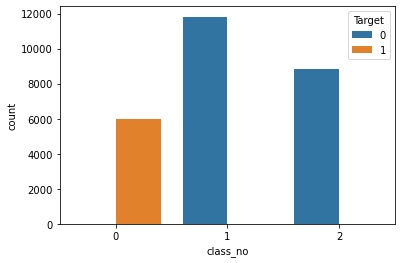

In [42]:
sns.countplot(x='class_no',hue='Target',data=df)

###### Obviously we have missing coordinates. We have coordinates for approximately only for 6k records.
###### Countplot gives same data where only class - 0 has set to Target 1 and remaining classes are set to Target = 0. THis means we have Target representing available coordinates (annotations) or not

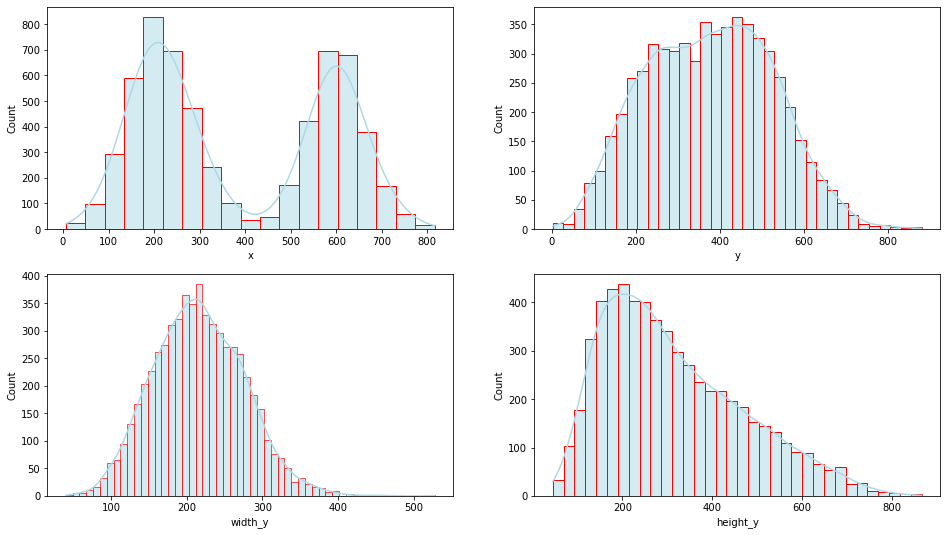

In [43]:
column = ['x','y','width_y','height_y']

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,9))
for idx, ax in zip(column, axes.flat):
    sns.histplot(data=df, x=idx, kde=True, color = "lightblue", ec="red", ax=ax)
plt.show()

##### The image marker has X from 0 to 800. The Y values are between 0 to 800 and we have few extrem in Y. Here X is kind of normally distributed with two lowest count. The Y is not normally distributed having right skew.
##### We have X 150 to 300, 550 to 700 having more number of reocrds. Similarly we have Y value 150 to 600 having more number of records. THe number of records are less than 50 in counts when the Y is beyond 60
##### Width_y is normally distributed and Height_Y is right skewed.
##### Overall we have average bounding box with some large boxes as well.

In [44]:
#plt.figure(figsize=(17,10))
#sns.boxplot(data=df)
#plt.show()

<AxesSubplot:>

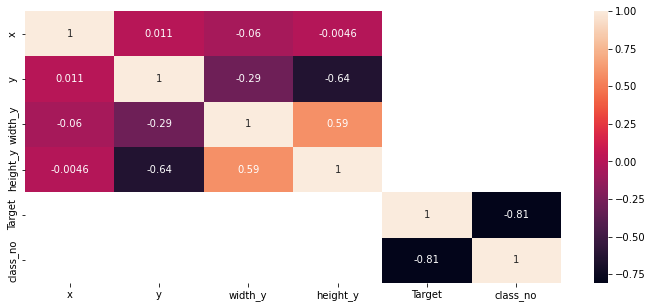

In [45]:
corr = df.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr,annot=True)

##### We don't have much coorrelation between variables however average coorelation can be seen between Width_y vs Height_y and negative average coorrelation can be seen between Y and Height_y

# Step - 5: Display images with bounding box

## Step - 5.1: Display random images with bounding box

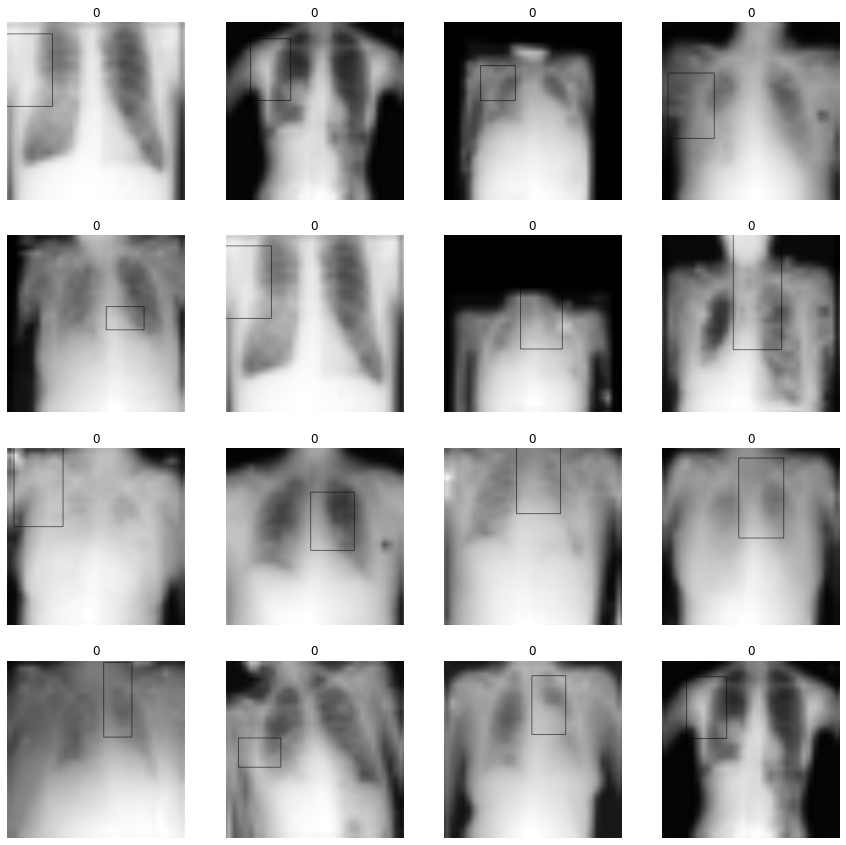

In [46]:
import cv2
import random

fig = plt.figure(figsize=(15, 15))
N=16
i = 0
#temp_df = df.query("x != nan").sample(n=200)
temp_df = df.loc[df['x'].notnull()]
temp_df = temp_df.sample(100, ignore_index=True)
#print(temp_df)
for i in range(1, N+1):
    loc = random.randint(1, (len(temp_df) - 1))
    fig.add_subplot(4, 4, i)

    x0 = temp_df.loc[loc, 'x'] - temp_df.loc[loc, 'width_y'] / 2
    x1 = temp_df.loc[loc, 'x'] + temp_df.loc[loc, 'width_y'] / 2
    y0 = temp_df.loc[loc, 'y'] - temp_df.loc[loc, 'height_y'] / 2
    y1 = temp_df.loc[loc, 'y'] + temp_df.loc[loc, 'height_y'] / 2
    
    #print(f"{x0},{x1},{y0},{y1}")
    start_point = (int(x0), int(y0))
    end_point = (int(x1), int(y1))
    
    plt.imshow(cv2.rectangle(st.resize(temp_df.loc[loc, 'actual_image'],  (1024, 1024)), start_point, 
                              end_point, color=(0,0,255), thickness=2), cmap=plt.cm.gray)
    #plt.imshow(st.resize(data.loc[loc, 'actual_image'],  (1024, 1024)),  cmap=plt.cm.gray)
    #plt.title(temp_df.loc[loc, 'class_no'])
    plt.axis('off')
plt.show()

# Step - 6: Design, train and test basic CNN models for classification

## Step - 6.1: Split X & Y and get train and test

In [47]:
X = df['actual_image']     
Y = df['class_no']

In [48]:
X

0        [[8.286463581287197e-05, 4.041750331910769e-05...
1        [[7.194814904496719e-05, 0.0002037581145740258...
2        [[4.487527018563684e-05, 4.5375053597157953e-0...
3        [[0.0002417167778605627, 0.0002527935192363741...
4        [[6.772987099858779e-05, 0.0003000979514369435...
                               ...                        
26679    [[7.163705612606939e-05, 6.700455796513645e-05...
26680    [[4.6134528863375316e-05, 4.610083468755934e-0...
26681    [[0.0003491565798057978, 0.000770259978522427,...
26682    [[1.344063738425597e-05, 4.654971683902636e-07...
26683    [[0.00026488671541695987, 0.000284427266758785...
Name: actual_image, Length: 26684, dtype: object

## Step - 6.1 Convert to tensor and start basic classification model

In [49]:
# For validation of model result have test:train:validation split
# It will help understand model accuracy
from sklearn.model_selection import train_test_split

def train_test_val_split(X,Y):
    train_ratio = 0.75
    validation_ratio = 0.10
    test_ratio = 0.15
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1 - train_ratio)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))
    print(f"{x_train.shape} is x_train shape, {x_test.shape} x_test shape, {x_val.shape} x_val shape, {y_train.shape} is y_train shape, {y_test.shape} y_test shape, {y_val.shape} y_val shape")
    return x_train, x_test, x_val, y_train, y_test, y_val

In [50]:
import torch
import torchvision.transforms as transforms
import tensorflow as tf

In [51]:
x_train, x_test, x_val, y_train, y_test, y_val = train_test_val_split(X, Y)

(20013,) is x_train shape, (4003,) x_test shape, (2668,) x_val shape, (20013,) is y_train shape, (4003,) y_test shape, (2668,) y_val shape


###### We have 75% data allocated for training, 15% for testing and 10% for validation.

In [52]:
from skimage.color import gray2rgb

X_train = gray2rgb(x_train.to_list())
X_test = gray2rgb(x_test.to_list())
X_val = gray2rgb(x_val.to_list())

In [53]:
print(f"{X_train.shape} is X_train shape, {X_test.shape} X_test shape, {X_val.shape} is X_val shape, {y_train.shape} is y_train shape, {y_test.shape} y_test shape, {y_val.shape} y_val shape")

(20013, 32, 32, 3) is X_train shape, (4003, 32, 32, 3) X_test shape, (2668, 32, 32, 3) is X_val shape, (20013,) is y_train shape, (4003,) y_test shape, (2668,) y_val shape


## Step - 6.3 Build basic CNN model with three convulution layer with sofmax for multi- classification

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Activation, Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
def get_model():
    model = Sequential()
    
    model.add(InputLayer(input_shape = (32,32,3,)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    
    model.add(Dense(3, activation='softmax'))
    return model

In [56]:
model = get_model()
model.compile(optimizer='SGD', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 dense (Dense)               (None, 26, 26, 128)       1

In [57]:
BATCH_SIZE = 32
earlyStoppingCallback = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs = 25, batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test))#,  callbacks=[earlyStoppingCallback])

Epoch 1/25
626/626 [==============================] - 185s 285ms/step - loss: 2.8214 - accuracy: 0.5125 - val_loss: 0.9931 - val_accuracy: 0.4512
Epoch 2/25
626/626 [==============================] - 146s 233ms/step - loss: 0.8435 - accuracy: 0.5954 - val_loss: 1.1013 - val_accuracy: 0.4941
Epoch 3/25
626/626 [==============================] - 174s 278ms/step - loss: 0.8094 - accuracy: 0.6146 - val_loss: 0.8048 - val_accuracy: 0.6065
Epoch 4/25
626/626 [==============================] - 167s 267ms/step - loss: 0.7890 - accuracy: 0.6289 - val_loss: 0.8110 - val_accuracy: 0.6098
Epoch 5/25
626/626 [==============================] - 150s 240ms/step - loss: 0.7726 - accuracy: 0.6386 - val_loss: 0.9491 - val_accuracy: 0.5716
Epoch 6/25
626/626 [==============================] - 139s 222ms/step - loss: 0.7583 - accuracy: 0.6475 - val_loss: 0.8597 - val_accuracy: 0.5836
Epoch 7/25
626/626 [==============================] - 148s 236ms/step - loss: 0.7430 - accuracy: 0.6588 - val_loss: 0.8146 -

## Step - 6.4: Plot accuracy and loss

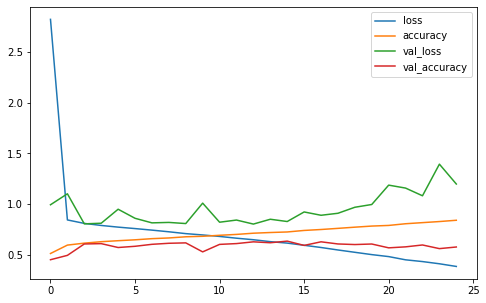

In [58]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

## Step - 6.5 The accuracy of training is showing small improvements and testing was little going up and down. 

In [59]:
from sklearn.metrics import classification_report

In [62]:
y_val_prediction_model = model.predict(X_val)
y_val_prediction=[]
for i in y_val_prediction_model:
  y_val_prediction.append(np.argmax(i))

cr = classification_report(y_val,y_val_prediction)
print(cr)

#classification_report(label_encoder.inverse_transform(y_val),label_encoder.inverse_transform(y_val_prediction)

84/84 [==============================] - 5s 49ms/step
              precision    recall  f1-score   support

           0       0.45      0.46      0.45       596
           1       0.55      0.59      0.57      1160
           2       0.71      0.64      0.67       912

    accuracy                           0.58      2668
   macro avg       0.57      0.56      0.56      2668
weighted avg       0.58      0.58      0.58      2668



In [63]:
from sklearn.metrics import confusion_matrix

<AxesSubplot:>

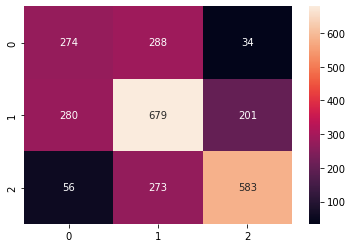

In [64]:
confusion_mtx = confusion_matrix(y_val, y_val_prediction)
sns.heatmap(confusion_mtx, annot=True, fmt='d')

###### Model is doing bad prediction on predicting Lung Opacity. The accuracy is low as 58, also the model is start over fitting after 10 to 15 epoch. 

## Step - 6.6  Few images with actual VS predicted label 

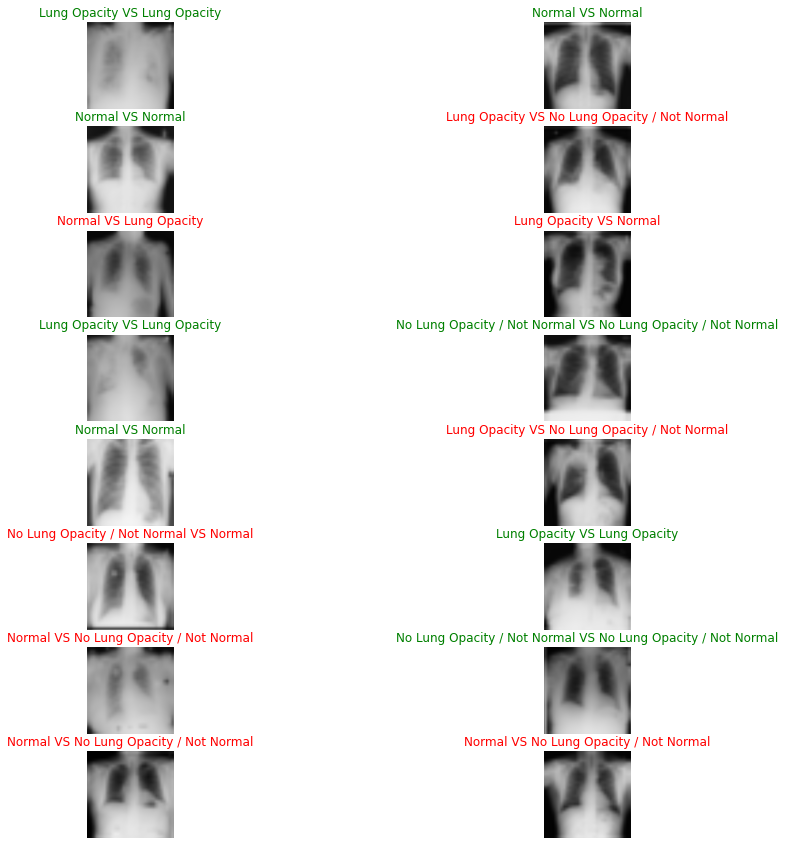

In [130]:
fig = plt.figure(figsize=(15, 15))
N=16
for i in range(1, N+1):
    loc = random.randint(1, len(X_val))
    actual = label_encoder.inverse_transform(y_val)[loc]
    predicted = label_encoder.inverse_transform(y_val_prediction)[loc] 
    if (actual == predicted):
        params = {"text.color" : "green"}
    else:
        params = {"text.color" : "red"}
    plt.rcParams.update(params)
    fig.add_subplot(8, 2, i)
    plt.imshow(st.resize(X_val[loc] * 255,  (1024, 1024)))
    plt.title(actual + ' VS ' + predicted)
    plt.axis('off')
plt.show()

##### Text color in green shows correct prediction and red in color shows wrong prediction. We have more wrong predictions and they are mixed as such normal is predicted as No lung Opacity/Not normal, Lung Opacity, etc.

##### The model is giving 46% recall on predicting lung opacity and 64 % on normal class which again not great. We will be doing further optimization for this model like Image Augmentation, Parameter tunning such updating learning rate, trying with Adam Optimizer, transfer learning optimization and trying with more convulution layer, etc in the second phase

# Step - 7: Interim Report

##### The interim report is created and will be submitted separately.